# Processing raw texts

In [1]:
import collections
import re
from d2l import torch as d2l

## Load dataset

In [2]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

In [3]:
def read_time_machine():
    with open(d2l.download('time_machine'),'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]

In [4]:
lines = read_time_machine()

In [5]:
print(f'Total rows: {len(lines)}')
print(lines[0])
print(lines[10])

Total rows: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## Tokenization

In [6]:
def tokenize(lines,token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print(f'Error: unknown token <{token}>')

In [7]:
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## Vocabulary

In [8]:
class Vocab:
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),key=lambda x:x[1],reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token:idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
                
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0],list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [9]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [10]:
for i in [0,10]:
    print('text:',tokens[i])
    print('index:',vocab[tokens[i]])

text: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
index: [1, 19, 50, 40, 2183, 2184, 400]
text: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
index: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


## Integration of all functions

In [11]:
def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines,'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [12]:
corpus, vocab = load_corpus_time_machine()

In [13]:
len(corpus)

170580

In [14]:
len(vocab)

28

## Language statistics

In [15]:
import random
import torch
from d2l import torch as d2l

In [16]:
tokens = tokenize(read_time_machine())

In [17]:
corpus = [token for line in tokens for token in line]

In [18]:
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

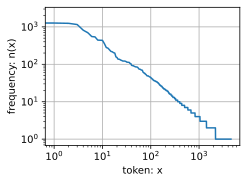

In [19]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x',ylabel='frequency: n(x)',xscale='log',yscale='log')

In [20]:
bigram_tokens = [pair for pair in zip(corpus[:-1],corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [21]:
trigram_tokens = [triple for triple in zip(corpus[:-2],corpus[1:-1],corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

In [22]:
quargram_tokens = [quarter for quarter in zip(corpus[:-3],corpus[1:-2],corpus[2:-1],corpus[3:])]
quargram_vocab = Vocab(quargram_tokens)
quargram_vocab.token_freqs[:10]

[(('said', 'the', 'time', 'traveller'), 12),
 (('said', 'the', 'medical', 'man'), 11),
 (('it', 'seemed', 'to', 'me'), 11),
 (('palace', 'of', 'green', 'porcelain'), 8),
 (('the', 'time', 'machine', 'and'), 7),
 (('as', 'i', 'did', 'so'), 7),
 (('the', 'palace', 'of', 'green'), 7),
 (('the', 'time', 'traveller', 's'), 6),
 (('of', 'the', 'time', 'machine'), 6),
 (('the', 'time', 'machine', 'i'), 6)]

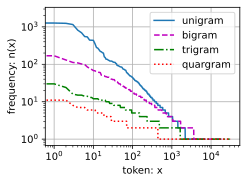

In [23]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
quargram_freqs = [freq for token, freq in quargram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs, quargram_freqs],
         xlabel='token: x',ylabel='frequency: n(x)',
         xscale='log',yscale='log',
         legend=['unigram','bigram','trigram','quargram'])

## Read sequential data

### Random sampling

In [24]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    corpus = corpus[random.randint(0,num_steps-1):]
    num_subseqs = (len(corpus) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)
    
    def data(pos):
        return corpus[pos:pos+num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [25]:
my_seq = list(range(35))
for X,Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}\nY: {Y}')

X: tensor([[ 2,  3,  4,  5,  6],
        [27, 28, 29, 30, 31]])
Y: tensor([[ 3,  4,  5,  6,  7],
        [28, 29, 30, 31, 32]])
X: tensor([[ 7,  8,  9, 10, 11],
        [22, 23, 24, 25, 26]])
Y: tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]])
X: tensor([[12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]])
Y: tensor([[13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22]])


In [26]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset :offset+num_tokens])
    Ys = torch.tensor(corpus[offset+1:offset+1+num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:,i:i+num_steps]
        Y = Ys[:,i:i+num_steps]
        yield X,Y

In [27]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}\nY: {Y}')

X: tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]])
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X: tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]])
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X: tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]])
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [28]:
class SeqDataLoader:
    def __init__(self,batch_size,num_steps,use_random_iter,max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
        
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [29]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,max_tokens)
    return data_iter, data_iter.vocab

# 8.4 Recurrent Neural Network

In [30]:
import torch
from d2l import torch as d2l

In [31]:
batch_size = 10
input_dim = 1
hidden_dim = 4
output_dim = 3
X, W_xh = torch.normal(0,1,(batch_size,input_dim)), torch.normal(0,1,(input_dim,hidden_dim))
H, W_hh = torch.normal(0,1,(batch_size,hidden_dim)), torch.normal(0,1,(hidden_dim,hidden_dim))
W_hq = torch.normal(0,1,(hidden_dim,output_dim))
y_hat = (X @ W_xh + H @ W_hh) @ W_hq
print(y_hat.shape)
print(y_hat)

torch.Size([10, 3])
tensor([[  2.5706,   2.8726,   0.9815],
        [  6.5733,  -3.1803,   1.7454],
        [  0.4997,  -6.7674,  -0.5261],
        [ -1.0197,  -6.4695,  -0.9428],
        [ -0.5494,   7.6981,   0.2103],
        [ -0.4961, -16.1384,  -1.5744],
        [  0.6295,   1.3615,   0.2191],
        [ -0.8872,  11.3167,  -0.5594],
        [ -1.4911,   5.9128,  -0.3805],
        [  4.6276,   8.4605,   2.2981]])


# 8.5 RNN from scratch

In [32]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [33]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

## One-hot encoding

In [34]:
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [35]:
X = torch.arange(10).reshape((2,5))
F.one_hot(X.T,28).shape

torch.Size([5, 2, 28])

In [36]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [37]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [41]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [42]:
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self,X,state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self,batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [43]:
num_hiddens = 512
net = RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,init_rnn_state,rnn)
state = net.begin_state(X.shape[0],d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [46]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape((1,1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [47]:
predict_ch8('time traveller ',10, net, vocab, d2l.try_gpu())

'time traveller svnqwfagmj'

In [53]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params ))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [60]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state,tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device),y.to(device)
        y_hat, state = net(X,state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [61]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',ylabel='perplexity',legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(),lr)
    else:
        updater = lambda batch_size:d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
        net, train_iter, loss, updater, device, use_random_iter)
        if (epoch+1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1,[ppl])
    print(f'Perplexity: {ppl:.1f}, {speed:.1f}token/sec {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Perplexity: 1.2, 20818.7token/sec cpu
time traveller held in his hand was a glitteringmetallic fromems
traveller ou can shid bed ard and and te cankly thee in ian


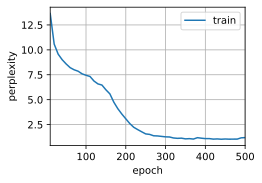

In [63]:
num_epochs, lr = 500,1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [68]:
predict = lambda prefix: predict_ch8(prefix, 60, net, vocab, 'cpu')
print(predict('time'))

time traveller held in his hand was a glitteringmetallic fromems


Perplexity: 1.5, 10874.8token/sec cpu
time travellerit s against reason said filbywan argumentative pe
travellerit s against reason said filbywan argumentative pe


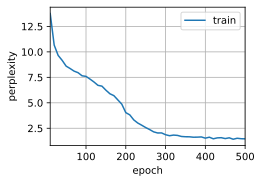

In [70]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,init_rnn_state,rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),use_random_iter=True)